# Mass predicition studies for faba bean seeds
Author: Harpreet Kaur Bargota
Date: Dec 4, 2025


## Import the libraries and read the ground truth .csv file

In [1]:
#import the libraries required for analysis
import pandas as pd
import seaborn as sns
import cv2
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import time
import numpy as np
import matplotlib.pyplot as plt
# import functions from sklearn
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score, explained_variance_score)
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

In [2]:
#Read the hand and machine measured data
Mass_pred = pd.read_excel("Faba_Seed_Analyzer_Data_August_2024.xlsx", sheet_name= "Mean S2 Seed Data")

In [3]:
# display the head
Mass_pred.head(4)

,ID,Main Seed,Main Seeds,Weight(g),TGW(g),Seeds/kg,"""B-Stocking""/Non-Seeds",Date,Time,ØArea,...,Max Width,Max Length,Volume(ml),Volume Weight(kg/hl),ØCircularity,Min Circularity,Max Circularity,ØL/W Ratio,Min L/W Ratio,Max L/W Ratio
0,Vf1-1-2,Vicia faba,4,4.8877,1221.925000,818.380834,8,13/06/2023,14:38,219.500247,...,14.532204,21.097440,15,32.584667,1.168153,1.162423,1.173740,1.368314,1.291562,1.451772
1,Vf4-1-1,Vicia faba,6,1.9316,321.933333,3106.233175,7,13/06/2023,14:40,54.012175,...,8.224431,10.592581,15,12.877333,1.145160,1.126615,1.155499,1.238091,1.169780,1.294690
2,Vf7-1-1,Vicia faba,10,3.5681,356.810000,2802.612034,9,13/06/2023,14:42,65.235907,...,8.462456,11.367768,15,23.787333,1.164687,1.135995,1.187734,1.351447,1.251236,1.429181
3,Vf8-1-1,Vicia faba,9,3.8984,433.155556,2308.639442,9,13/06/2023,14:43,70.955747,...,9.208415,12.489041,15,25.989333,1.161806,1.151720,1.179324,1.317772,1.249530,1.399287


In [4]:
# check the columns
Mass_pred.columns

Index(['ID', 'Main Seed', 'Main Seeds', 'Weight(g)', 'TGW(g)', 'Seeds/kg',
       '"B-Stocking"/Non-Seeds', 'Date', 'Time', 'ØArea', 'ØWidth', 'ØLength',
       'Min Width', 'Min Length', 'Max Width', 'Max Length', 'Volume(ml)',
       'Volume Weight(kg/hl)', 'ØCircularity', 'Min Circularity',
       'Max Circularity', 'ØL/W Ratio', 'Min L/W Ratio', 'Max L/W Ratio'],
      dtype='object')

## Data and Features: Get the necessary columns from dataframe 

In [5]:
Mp1=Mass_pred[['ID', 'Main Seeds', 'Weight(g)', 'TGW(g)', 'Seeds/kg',
       'ØArea', 'ØWidth', 'ØLength', 'Min Width', 'Min Length', 'Max Width', 'Max Length',
        'ØCircularity', 'Min Circularity',
       'Max Circularity', 'ØL/W Ratio', 'Min L/W Ratio', 'Max L/W Ratio']]

In [6]:
Mp1.head(4)

,ID,Main Seeds,Weight(g),TGW(g),Seeds/kg,ØArea,ØWidth,ØLength,Min Width,Min Length,Max Width,Max Length,ØCircularity,Min Circularity,Max Circularity,ØL/W Ratio,Min L/W Ratio,Max L/W Ratio
0,Vf1-1-2,4,4.8877,1221.925000,818.380834,219.500247,14.314509,19.600875,13.820892,17.850534,14.532204,21.097440,1.168153,1.162423,1.173740,1.368314,1.291562,1.451772
1,Vf4-1-1,6,1.9316,321.933333,3106.233175,54.012175,7.435900,9.232743,6.420532,7.520082,8.224431,10.592581,1.145160,1.126615,1.155499,1.238091,1.169780,1.294690
2,Vf7-1-1,10,3.5681,356.810000,2802.612034,65.235907,7.909650,10.681146,7.491855,9.937081,8.462456,11.367768,1.164687,1.135995,1.187734,1.351447,1.251236,1.429181
3,Vf8-1-1,9,3.8984,433.155556,2308.639442,70.955747,8.330176,10.984360,7.683458,9.743898,9.208415,12.489041,1.161806,1.151720,1.179324,1.317772,1.249530,1.399287


The dataset contains multiple predictor variables (features) and one target variable- TGW(g). 
The features used in the study are:
Numerical Features:
•Main Seeds, ØArea, ØWidth, ØLength, Min Width, Min Length, Max Width, Max Length, ØCircularity, Min Circularity, Max Circularity, ØL/W Ratio, Min L/W Ratio, Max L/W Ratio

Categorical Features:
•ID (used for one-hot encoding)

Target Variable: TGW(g)



## Methodology


### Make pipeline to preprocess the data

In [7]:
features = ['ID', 'Main Seeds', 'ØArea', 'ØWidth', 'ØLength', 'Min Width', 'Min Length', 'Max Width', 'Max Length',
            'ØCircularity', 'Min Circularity', 'Max Circularity', 'ØL/W Ratio', 'Min L/W Ratio', 'Max L/W Ratio']
target = 'TGW(g)'

X = Mp1[features]
y = Mp1[target]

To facilitate preprocessing of a dataset with mixed data types, use the make_column_selector utility from the sklearn.compose module. This approach allows for dynamic selection of columns based on their data types, which is particularly useful in machine learning pipelines where categorical and numerical features often require different preprocessing steps.
cat_selector: This selector identifies all columns in the dataset X that contain object-type data, typically representing categorical variables.
num_selector: This selector identifies all columns with numeric data types (e.g., integers and floats), which are typically used for numerical analysis and modeling.
cat_selector(X): This line applies the categorical selector to the dataset X, returning a list of column names that contain categorical data. This output can then be used to apply specific preprocessing steps such as one-hot encoding or imputation.
num_selector(X): Selects columns with numeric data types such as int64 and float64.

In [8]:
from sklearn.compose import make_column_selector

cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)
cat_selector(X)

['ID']

In [9]:
num_selector(X)

['Main Seeds',
 'ØArea',
 'ØWidth',
 'ØLength',
 'Min Width',
 'Min Length',
 'Max Width',
 'Max Length',
 'ØCircularity',
 'Min Circularity',
 'Max Circularity',
 'ØL/W Ratio',
 'Min L/W Ratio',
 'Max L/W Ratio']

### Design the pipeline required for the tree-based models.
This preprocessing pipeline is designed for tree-based models. It uses an OrdinalEncoder to convert categorical variables into integers, handling unknown values with -1 and missing values with -2. For numerical features, a SimpleImputer fills missing values with the mean and adds indicators for missing entries. These steps are combined using make_column_transformer, applying each processor to the appropriate columns selected by num_selector and cat_selector. This setup ensures the data is clean and model-ready.

In [10]:
cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-2,
)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)

tree_preprocessor

ColumnTransformer(transformers=[('simpleimputer',
                                 SimpleImputer(add_indicator=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001D154262AD0>),
                                ('ordinalencoder',
                                 OrdinalEncoder(encoded_missing_value=-2,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001D15434E510>)])

## Define the preprocessor (oneHotencoding and normalization) Steps
This pipeline prepares data for linear models by one-hot encoding categorical features and scaling numerical ones. It uses OneHotEncoder to handle unknown categories and a pipeline of StandardScaler and SimpleImputer to normalize and impute missing numerical values. These steps are combined using make_column_transformer for efficient preprocessing.


In [11]:
cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)

linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
)
linear_preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001D154262AD0>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001D15434E510>)])

## Stack of predictors on the data set

### Linear regression
Machine learning pipeline for linear regression is created by combining preprocessing and modeling steps. The linear_pipeline uses make_pipeline to sequentially apply the linear_preprocessor, which prepares the data by encoding categorical features and scaling/imputing numerical ones, followed by fitting a LinearRegression model. This streamlined approach ensures that all necessary data transformations are applied consistently during both training and prediction, improving model reliability and simplifying deployment.

In [12]:
linear_pipeline = make_pipeline(linear_preprocessor, LinearRegression())
linear_pipeline


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D154262AD0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D15434E510>)])),
                ('linearregression', LinearRegression())])

### Random forest regression
After preprocessing, the data is passed to a RandomForestRegressor with a fixed random_state for reproducibility. 

In [13]:
rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(random_state=42))
rf_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D154262AD0>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D15434E510>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

### Gradient boosting
Machine learning pipeline for regression using a Gradient Boosting model is created as explained with the above models.


In [14]:
gbr_pipeline = make_pipeline(tree_preprocessor, GradientBoostingRegressor(random_state=0))
gbr_pipeline


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D154262AD0>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D15434E510>)])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(random_state=0))])

### Stacking regressor
To enhance regression performance, we implemented a stacked ensemble model using StackingRegressor. This method combines multiple diverse base models—Random Forest, Linear Regression, and Gradient Boosting—each encapsulated in its own preprocessing pipeline. These pipelines ensure that data is appropriately transformed for each model type, with tree-based models using ordinal encoding and imputation, and the linear model using one-hot encoding and scaling.
The outputs of these base models are then used as input features for a final estimator, RidgeCV, which is a regularized linear regression model with built-in cross-validation. This final model learns the optimal way to combine the predictions of the base models, leveraging their complementary strengths. The stacking approach is particularly effective when the base models capture different aspects of the data, leading to improved accuracy and robustness over any single model.

In [15]:
estimators = [
    ("Random Forest", rf_pipeline),
    ("Linear regression", linear_pipeline),
    ("Gradient Boosting", gbr_pipeline),
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
stacking_regressor

StackingRegressor(estimators=[('Random Forest',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('simpleimputer',
                                                                                 SimpleImputer(add_indicator=True),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001D154262AD0>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(encoded_missing_value=-2,
                                                                                                handle_unknown='use_encoded_value',
                                                                                                unkno...
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001D154262AD0>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(encoded_missing_value=-2,
                                                                                                handle_unknown='use_encoded_value',
                                                                                                unknown_value=-1),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001D15434E510>)])),
                                               ('gradientboostingregressor',
                                                GradientBoostingRegressor(random_state=0))]))],
                  final_estimator=RidgeCV())

## Training and testing on the original dataset
To evaluate and compare the performance of multiple regression models, including a stacked ensemble, a systematic cross-validation and visualization process was implemented. A copy of the original dataset was created to store model predictions. A 2x2 grid of subplots was defined to visualize prediction errors for each model. For each estimator—Random Forest, Linear Regression, Gradient Boosting, and the Stacking Regressor—cross-validation was performed using cross_validate to compute R² and MAE scores. Out-of-fold predictions were generated using cross_val_predict and stored in the dataset for further analysis.
Model performance was visualized using PredictionErrorDisplay, which plots actual versus predicted values to assess prediction accuracy and bias. Each plot was annotated with evaluation metrics and computation time, providing a comprehensive view of each model’s effectiveness. This methodology ensures fair comparison across models and highlights the potential benefits of model stacking in regression tasks.

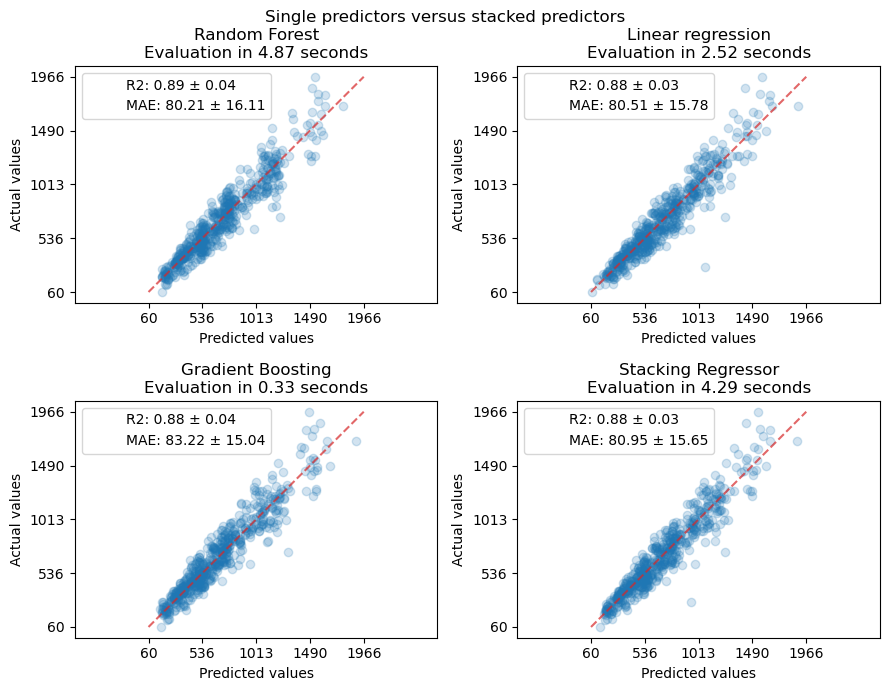

In [16]:
# Copy of the original dataframe to store predictions
df_pred = Mp1.copy()

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators + [("Stacking Regressor", stacking_regressor)]):
    scorers = {"R2": "r2", "MAE": "neg_mean_absolute_error"}

    start_time = time.time()
    scores = cross_validate(est, X, y, scoring=list(scorers.values()), n_jobs=-1, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)

    # Add predictions to the DataFrame with a clear column name
    col_name = f"y_pred_{name.replace(' ', '_').lower()}"
    df_pred[col_name] = y_pred

    scores = {
        key: (
            f"{np.abs(np.mean(scores[f'test_{value}'])):.2f} ± "
            f"{np.std(scores[f'test_{value}']):.2f}"
        )
        for key, value in scorers.items()
    }

    display = PredictionErrorDisplay.from_predictions(
        y_true=y,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
    ax.set_title(f"{name}\nEvaluation in {elapsed_time:.2f} seconds")

    for metric_name, score_text in scores.items():
        ax.plot([], [], " ", label=f"{metric_name}: {score_text}")
    ax.legend(loc="upper left")

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig("Manymodels_MP.JPG", format="jpg", dpi=300)
plt.show()


Interpretation
1. Random Forest achieved the highest R² score (0.89), indicating the best fit to the data among the models. It also had a relatively low MAE, suggesting good predictive accuracy.
2. Linear Regression performed nearly as well in terms of R² and MAE, but with a significantly faster evaluation time (0.05 seconds), making it highly efficient for quick predictions.
3. Gradient Boosting had slightly lower performance metrics and a longer evaluation time than Linear Regression, offering no clear advantage.
4. Stacking Regressor matched Linear Regression in R² and MAE but had the longest evaluation time.

In [17]:
df_pred.head(2)

,ID,Main Seeds,Weight(g),TGW(g),Seeds/kg,ØArea,ØWidth,ØLength,Min Width,Min Length,...,ØCircularity,Min Circularity,Max Circularity,ØL/W Ratio,Min L/W Ratio,Max L/W Ratio,y_pred_random_forest,y_pred_linear_regression,y_pred_gradient_boosting,y_pred_stacking_regressor
0,Vf1-1-2,4,4.8877,1221.925000,818.380834,219.500247,14.314509,19.600875,13.820892,17.850534,...,1.168153,1.162423,1.173740,1.368314,1.291562,1.451772,1194.501419,1221.240166,1179.753375,1197.337027
1,Vf4-1-1,6,1.9316,321.933333,3106.233175,54.012175,7.435900,9.232743,6.420532,7.520082,...,1.145160,1.126615,1.155499,1.238091,1.169780,1.294690,297.278900,294.239034,261.776236,292.767439


### Test data preparation for SAM2.1-generated data for Prediction studies
The test data was extracted in the same format as the original training data.

In [18]:
#read the .csv file for SAM2.1 data
SAM2=pd.read_csv(r"C:\Users\bargotah\Downloads\output_nov27\FE_Color.csv")

SAM2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4233 entries, 0 to 4232
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Seed No. per image          4233 non-null   int64  
 1   Class                       4233 non-null   object 
 2   Area-SAM(mm2)               4233 non-null   float64
 3   Length-SAM(mm)              4233 non-null   float64
 4   Width-SAM(mm)               4233 non-null   float64
 5   Perimeter-SAM(mm)           4233 non-null   float64
 6   Area-SAM_taubin(mm2)        4233 non-null   float64
 7   Length-SAM_taubin(mm)       4233 non-null   float64
 8   Width-SAM_taubin(mm)        4233 non-null   float64
 9   Perimeter-SAM_taubin(mm)    4233 non-null   float64
 10  Area-SAM_minEnc(mm2)        4233 non-null   float64
 11  Length-SAM_minEnc(mm)       4233 non-null   float64
 12  Width-SAM_minEnc(mm)        4233 non-null   float64
 13  Perimeter-SAM_minEnc(mm)    4233 

In [19]:
# Extract the value after the last underscore for column ``ÎD`` for column ``Class``
SAM2['ID'] = SAM2['Class'].str.split('_').str[-1]

# print the first 2 rows of df
print (SAM2.head(2))

   Seed No. per image                   Class  Area-SAM(mm2)  Length-SAM(mm)  \
0                   0  Faba-Seed-CC_Vf447-1-1      96.047573       11.248159   
1                   1  Faba-Seed-CC_Vf447-1-1      90.111920       10.808319   

   Width-SAM(mm)  Perimeter-SAM(mm)  Area-SAM_taubin(mm2)  \
0      10.770226          34.610325             94.820851   
1      10.496649          33.291382             88.961008   

   Length-SAM_taubin(mm)  Width-SAM_taubin(mm)  Perimeter-SAM_taubin(mm)  ...  \
0              12.447068              9.756425                 37.090704  ...   
1              11.960346              9.508600                 35.677237  ...   

   Compactness  Circularity-SAM                             Shape  \
0     0.882754         1.154560  Elongated,Oval,Elongated,Ellipse   
1     0.889838         1.138604  Elongated,Oval,Elongated,Ellipse   

   Shapefactor1  Shapefactor2  Shapefactor3  Shapefactor4  RGB value of Seed  \
0      0.005105      0.004002      0.779255

In [20]:
# get the df with the required features
SAM2_1=SAM2[['Seed No. per image', 'ID', 'Area-SAM_taubin(mm2)', 'Length-SAM_taubin(mm)', 'Width-SAM_taubin(mm)','Circularity-SAM','Aspect Ratio']]
print (SAM2_1.head(10))

   Seed No. per image         ID  Area-SAM_taubin(mm2)  Length-SAM_taubin(mm)  \
0                   0  Vf447-1-1             94.820851              12.447068   
1                   1  Vf447-1-1             88.961008              11.960346   
2                   2  Vf447-1-1             88.740168              12.034672   
3                   3  Vf447-1-1             93.780177              12.901503   
4                   4  Vf447-1-1            102.147924              12.562562   
5                   5  Vf447-1-1            109.945418              14.514539   
6                   6  Vf447-1-1             99.084893              13.337874   
7                   0  Vf498-1-1            132.737335              14.980025   
8                   1  Vf498-1-1            130.251986              14.865348   
9                   2  Vf498-1-1            136.663116              15.473414   

   Width-SAM_taubin(mm)  Circularity-SAM  Aspect Ratio  
0              9.756425         1.154560      1.275

### Feature engineering: 
Since the original data had the average data, new coulmns were created which should have the average data for each bean line.

In [21]:
# create a new df with the required average data for each parameter
new_df = (
    SAM2_1.groupby('ID').agg(
        **{
            'Main Seeds':        ('Seed No. per image', 'count'),
            'ØArea':             ('Area-SAM_taubin(mm2)', 'mean'),
            'ØWidth':            ('Width-SAM_taubin(mm)', 'mean'),
            'ØLength':           ('Length-SAM_taubin(mm)', 'mean'),
            'Min Width':         ('Width-SAM_taubin(mm)', 'min'),
            'Min Length':        ('Length-SAM_taubin(mm)', 'min'),
            'Max Width':         ('Width-SAM_taubin(mm)', 'max'),
            'Max Length':        ('Length-SAM_taubin(mm)', 'max'),
            'ØCircularity':      ('Circularity-SAM', 'mean'),
            'Min Circularity':   ('Circularity-SAM', 'min'),
            'Max Circularity':   ('Circularity-SAM', 'max'),
            'ØL/W Ratio':        ('Aspect Ratio', 'mean'),
            'Min L/W Ratio':     ('Aspect Ratio', 'min'),
            'Max L/W Ratio':     ('Aspect Ratio', 'max'),
        }
    )
    .reset_index()
)

# Reorder columns 
new_df = new_df[[
    'ID', 'Main Seeds', 'ØArea', 'ØWidth', 'ØLength',
    'Min Width', 'Min Length', 'Max Width', 'Max Length',
    'ØCircularity', 'Min Circularity', 'Max Circularity',
    'ØL/W Ratio', 'Min L/W Ratio', 'Max L/W Ratio'
]]

print(new_df.head(2))

          ID  Main Seeds       ØArea     ØWidth    ØLength  Min Width  \
0    Vf1-1-2           4  225.330470  14.267950  20.115113  13.260288   
1  Vf100-1-2          10  142.666332  12.069708  15.005968  11.158714   

   Min Length  Max Width  Max Length  ØCircularity  Min Circularity  \
0   18.277750  14.903931   21.093728      1.172945         1.161044   
1   12.722019  13.747600   18.679798      1.158626         1.137500   

   Max Circularity  ØL/W Ratio  Min L/W Ratio  Max L/W Ratio  
0         1.192171    1.409362       1.374182       1.472527  
1         1.183792    1.239627       1.108873       1.400065  


### Prediction on test dataset

In [22]:
# PRediction on test data
df_pred_test = new_df.copy()  # Create a new DataFrame for test predictions

for name, est in estimators + [("Stacking Regressor", stacking_regressor)]:
    # Fit the model on the full training data
    est.fit(X, y)
    
    # Predict on the test set
    y_pred_test = est.predict(df_pred_test)
    
    # Add predictions to the DataFrame
    col_name = f"y_pred_{name.replace(' ', '_').lower()}"
    df_pred_test[col_name] = y_pred_test


In [23]:
df_pred_test.head(2)

,ID,Main Seeds,ØArea,ØWidth,ØLength,Min Width,Min Length,Max Width,Max Length,ØCircularity,Min Circularity,Max Circularity,ØL/W Ratio,Min L/W Ratio,Max L/W Ratio,y_pred_random_forest,y_pred_linear_regression,y_pred_gradient_boosting,y_pred_stacking_regressor
0,Vf1-1-2,4,225.330470,14.267950,20.115113,13.260288,18.277750,14.903931,21.093728,1.172945,1.161044,1.192171,1.409362,1.374182,1.472527,1233.45845,1248.835304,1246.481095,1241.054795
1,Vf100-1-2,10,142.666332,12.069708,15.005968,11.158714,12.722019,13.747600,18.679798,1.158626,1.137500,1.183792,1.239627,1.108873,1.400065,749.06486,617.650168,727.974563,691.458899


### Results of Predicted mass TGW(g) for SAM-generated data

In [24]:
# Optionally: View or save
print(df_pred_test[['ID', 'y_pred_stacking_regressor']].head(20))

           ID  y_pred_stacking_regressor
0     Vf1-1-2                1241.054795
1   Vf100-1-2                 691.458899
2   Vf101-1-3                 463.465288
3   Vf102-1-3                1270.090693
4   Vf103-1-2                 251.598503
5   Vf104-1-2                 359.097548
6   Vf106-1-2                 413.394759
7   Vf107-1-3                1366.830645
8   Vf108-1-1                 421.670844
9   Vf109-1-1                 911.630042
10   Vf11-1-1                 359.718720
11  Vf110-1-3                 936.338747
12  Vf110-1-4                 674.831655
13  Vf111-1-1                 477.936730
14  Vf112-1-2                1114.909248
15  Vf113-1-2                 720.115282
16  Vf114-1-2                 271.544569
17  Vf115-1-2                 232.189245
18  Vf116-3-2                 822.124629
19  Vf117-1-2                 146.306996


In [25]:
new_df = pd.merge(Mp1, df_pred_test, on='ID')
df_t=new_df[['ID', 'TGW(g)', 'y_pred_stacking_regressor']]

In [26]:
df_t.head(2)

,ID,TGW(g),y_pred_stacking_regressor
0,Vf1-1-2,1221.925000,1241.054795
1,Vf4-1-1,321.933333,329.256711


In [27]:
# Function to plot regression with stats
def plot_regression_with_stats(df, x_col, y_col):
    x = df[x_col]
    y = df[y_col]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    plt.figure(figsize=(8, 5))
    sns.regplot(x=x, y=y, ci=95, line_kws={'color': 'red'})

    stats_text = (f"Slope = {slope:.2f}\n"
                  f"Intercept = {intercept:.2f}\n"
                  f"R² = {r_value**2:.3f}\n"
                  f"95% CI Shaded")

    plt.title(f"Regression of {y_col} on {x_col}")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.text(0.05, 0.95, stats_text,
             transform=plt.gca().transAxes,
             fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.4", fc="lightyellow", ec="black", lw=1))

    plt.grid(True)
    plt.tight_layout()
    plt.savefig("TGW.jpg", format="jpg")
    plt.show()


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

def plot_regression_with_stats(df, x_col, y_col, filename="TGW.jpg", dpi=300, show_grid=True):
    x = df[x_col]
    y = df[y_col]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    plt.figure(figsize=(8, 5))
    sns.regplot(x=x, y=y, ci=95, line_kws={'color': 'red'})

    stats_text = (f"Slope = {slope:.2f}\n"
                  f"Intercept = {intercept:.2f}\n"
                  f"R² = {r_value**2:.3f}\n"
                  f"95% CI Shaded")

    plt.title(f"Regression of {y_col} on {x_col}")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.text(0.05, 0.95, stats_text,
             transform=plt.gca().transAxes,
             fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.4", fc="lightyellow", ec="black", lw=1))

    plt.grid(show_grid)
    plt.tight_layout()
    plt.savefig(filename, format="jpg", dpi=dpi)
    plt.show()


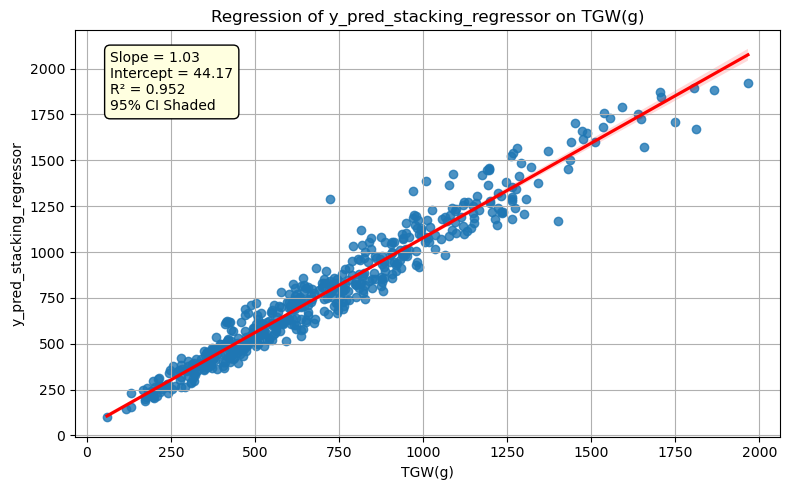

In [29]:
from statsmodels.stats.api import DescrStatsW
from scipy.stats import linregress

# Plot the regression
plot_regression_with_stats(df_t, 'TGW(g)', 'y_pred_stacking_regressor')


In [30]:
df_t.head(10)

,ID,TGW(g),y_pred_stacking_regressor
0,Vf1-1-2,1221.925000,1241.054795
1,Vf4-1-1,321.933333,329.256711
2,Vf7-1-1,356.810000,399.031202
3,Vf8-1-1,433.155556,445.124574
4,Vf9-1-1,456.450000,468.898144
5,Vf11-1-1,349.620000,359.718720
6,Vf13-1-1,822.450000,773.942332
7,Vf15-1-1,622.560000,639.158812
8,Vf16-1-1,706.714286,744.976002
9,Vf18-1-1,311.280000,360.119200


## Results: 
The regression analysis revealed a strong linear relationship between the predicted and actual thousand grain weight (TGW), as described by the equation: Predicted TGW (g) = 1.03 × Actual TGW (g) + 44.17. The model achieved a high coefficient of determination (R² = 0.952), indicating that 95.3% of the variance in the actual TGW is explained by the model’s predictions. The slope of 1.03 suggests that the model's predictions scale closely with the actual values, demonstrating good proportional accuracy. The intercept of 40.88 indicates the model's baseline prediction when the actual TGW is zero. Additionally, the 95% confidence interval, visually represented as a shaded region, illustrates the uncertainty associated with the model’s predictions, providing insight into the reliability of the regression estimates. Overall, these results suggest that the model performs excellently in predicting TGW.

## Conclusion
Overall, the Stacking Regressor not only maintained but enhanced its predictive power on new data, making it a robust and accurate model choice, especially when performance is prioritized over computational efficiency.

In [31]:
df_t.describe()


,TGW(g),y_pred_stacking_regressor
count,536.000000,536.000000
mean,699.003950,766.305038
std,349.098483,369.575101
min,59.800000,99.040298
25%,427.925833,480.445815
50%,635.083333,708.651585
75%,913.075000,996.114502
max,1966.166667,1919.211708
